In [ ]:
# Copyright (c) 2022 Massachusetts Institute of Technology
# SPDX-License-Identifier: MIT



# Evalulate Robustness of Adversarial Training

Adversarial Training is about solving for model parameters by evaluating against the worst-case loss:

$$
\hat{\theta} = \min_\theta \mathbb{E}_{(x,y) \sim D} \left[ \max\limits_{\|\delta\|_p<\epsilon} \mathcal{L}\left(f_\theta(x+\delta), y\right) \right]
$$

The code using `rAI-toolbox` boils down to simply running the following training loop:

```python
perturb_data = # define function to perturb the data
model = # load model
opt = Optim(model.parameters(), ...) # define optimizer
for epochs in range(num_epochs):
    for data, target in train_dataloader:
        perturbed_data = perturb_data(model, data, target, criterion)

        output = model(perturbed_data)
        loss = criterion(output, target)

        # Update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()

```

## Implementation

The code is organized as follows:

```
adversarial_training
├── configs.py :  hydra-zen configurations
├── solver.py  :  The LightningModule
└── train.py   :  Main function to train
```

### Training

Here we train a ResNet-50 on CIFAR-10 with $p=2$ and $\epsilon=1$. This should reproduce the same model available from [MadryLab](https://github.com/MadryLab/robustness).  To train simply execute `train.py`:

```bash
>> python train.py
```


### Results

In [1]:
%matplotlib inline
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

# Needed for `launch`
os.environ["PYTHONPATH"] = os.getcwd()

In [23]:
import configs
import pytorch_lightning as pl
from hydra_zen import builds, instantiate, launch, make_config
from rai_toolbox.mushin import load_experiment
from rai_toolbox.mushin._tasks import RobustnessCurve

#### Load Accuracy Metrics

Text(0, 0.5, 'accuracy')

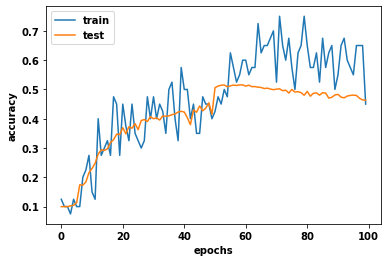

In [3]:
working_dir = "outputs/epsilon_1.0/2022-01-04/"
exps = load_experiment(working_dir)

metrics = exps.metrics["fit_metrics"]
plt.plot(metrics["epoch"], metrics["Train/Accuracy"], label="train")
plt.plot(metrics["epoch"], metrics["Val/Accuracy"], label="test")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")

#### Define Checkpoint

Given the accuracy over time, the best checkpoint happpens around epoch of 50 instead of the last checkpoint.

In [4]:
exps.ckpts

['/home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt',
 '/home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/last.ckpt']

In [5]:
best_ckpt = exps.ckpts[0]

#### Define Testing Configuration

In [6]:
DatasetCfg = make_config(
    batch_size=128,
    num_workers=8,
    dataset=None,
    val_dataset=None,
    test_dataset=builds(
        torch.utils.data.DataLoader,
        configs.TestCIFAR10,
        batch_size="${batch_size}",
        num_workers="${num_workers}",
        pin_memory=True,
    ),
)

TestConfig = make_config(
    random_seed=938390,
    ckpt=best_ckpt,
    bases=(DatasetCfg, configs.ModelCfg, configs.SolverCfg, configs.TrainerCfg),
)

#### Test Against a Defined Perturbation Strength

In [7]:
def test(cfg):
    pl.seed_everything(cfg.random_seed)
    obj = instantiate(cfg)
    obj.trainer.test(obj.module)

In [8]:
job = launch(TestConfig, test, overrides=["epsilon=1.0"])

Global seed set to 938390
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
[2022-03-10 22:22:16,176][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt
[2022-03-10 22:22:16,642][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt
Files already downloaded and verified
Files already downloaded and verified
[2022-03-10 22:22:20,776][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt


Global seed set to 938390
initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Global seed set to 938390
initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


[2022-03-10 22:22:23,069][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 1
[2022-03-10 22:22:23,074][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 0
[2022-03-10 22:22:23,075][torch.distributed.distributed_c10d][INFO] - Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



[2022-03-10 22:22:23,080][torch.distributed.distributed_c10d][INFO] - Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-22-15/lightning_logs
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-22-15/lightning_logs


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/Accuracy': 0.5144000053405762, 'Test/Loss': 1.2715364694595337}
--------------------------------------------------------------------------------


In [9]:
print(
    f"Test Accuracy for ϵ=1 is: {torch.load(Path(job.working_dir) / 'test_metrics.pt')['Test/Accuracy'][0] * 100:.2f}%"
)

Test Accuracy for ϵ=1 is: 51.44%


As shown in the "CIFAR10 L2-robust accuracy" table in the [README.md](https://github.com/MadryLab/robustness), we expect a test accuracy for $\epsilon = 1$ close to $52$%, exactly what we see above.

#### Robustness Curve

Launch a `RobustnessCurve` task to evaluate accuracy for different $\epsilon$ values.

In [14]:
class RobustnessCurveTask(RobustnessCurve):
    @staticmethod
    def evaluation_task(random_seed: int, trainer: pl.Trainer, module):
        trainer.test(module)
        assert Path("test_metrics.pt").exists()
        metrics = torch.load("test_metrics.pt")
        return metrics["Test/Accuracy"][-1]


def curve_task_fn(cfg):
    task = RobustnessCurveTask(cfg)
    launcher = None if "launcher" not in cfg else cfg.launcher
    task.run(job_epsilons=cfg.job_epsilon, launcher=launcher)
    print("Finished Job")
    print("")
    return task.to_xarray()

In [16]:
jobs = launch(TestConfig, curve_task_fn, overrides=["+job_epsilon=[0.0,0.25,1.0,2.0]"])

[2022-03-10 22:26:04,032][HYDRA] Launching 4 jobs locally
[2022-03-10 22:26:04,032][HYDRA] 	#0 : epsilon=0.0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
[2022-03-10 22:26:05,172][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt
Files already downloaded and verified
[2022-03-10 22:26:09,533][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt


Global seed set to 938390
initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Global seed set to 938390
initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


[2022-03-10 22:26:10,828][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 1
[2022-03-10 22:26:10,829][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 0
[2022-03-10 22:26:10,830][torch.distributed.distributed_c10d][INFO] - Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



[2022-03-10 22:26:10,838][torch.distributed.distributed_c10d][INFO] - Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-26-03/0/lightning_logs
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-26-03/0/lightning_logs


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/Accuracy': 0.7986999750137329, 'Test/Loss': 0.6478748917579651}
--------------------------------------------------------------------------------
[2022-03-10 22:26:40,314][HYDRA] 	#1 : epsilon=0.25


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
[2022-03-10 22:26:41,454][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt
Files already downloaded and verified
[2022-03-10 22:26:45,113][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt


Global seed set to 938390
initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Global seed set to 938390
initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


[2022-03-10 22:26:47,403][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 1
[2022-03-10 22:26:47,407][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 0
[2022-03-10 22:26:47,408][torch.distributed.distributed_c10d][INFO] - Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



[2022-03-10 22:26:47,413][torch.distributed.distributed_c10d][INFO] - Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-26-03/1/lightning_logs
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-26-03/1/lightning_logs


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/Accuracy': 0.7353000044822693, 'Test/Loss': 0.7643936276435852}
--------------------------------------------------------------------------------
[2022-03-10 22:27:17,410][HYDRA] 	#2 : epsilon=1.0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
[2022-03-10 22:27:18,674][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt
Files already downloaded and verified
[2022-03-10 22:27:23,036][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt


Global seed set to 938390
initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Global seed set to 938390
initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


[2022-03-10 22:27:24,352][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 1
[2022-03-10 22:27:24,355][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 0
[2022-03-10 22:27:24,355][torch.distributed.distributed_c10d][INFO] - Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



[2022-03-10 22:27:24,362][torch.distributed.distributed_c10d][INFO] - Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-26-03/2/lightning_logs
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-26-03/2/lightning_logs


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/Accuracy': 0.5144000053405762, 'Test/Loss': 1.271536946296692}
--------------------------------------------------------------------------------
[2022-03-10 22:27:53,976][HYDRA] 	#3 : epsilon=2.0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
[2022-03-10 22:27:55,198][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt
Files already downloaded and verified
[2022-03-10 22:27:58,598][rai_toolbox.mushin._utils][INFO] - Loading model checkpoint from /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/epsilon_1.0/2022-01-04/14-16-45/lightning_logs/version_0/checkpoints/epoch_52.ckpt


Global seed set to 938390
initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
Global seed set to 938390
initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


[2022-03-10 22:28:00,816][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 1
[2022-03-10 22:28:00,827][torch.distributed.distributed_c10d][INFO] - Added key: store_based_barrier_key:1 to store for rank: 0
[2022-03-10 22:28:00,827][torch.distributed.distributed_c10d][INFO] - Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------



[2022-03-10 22:28:00,837][torch.distributed.distributed_c10d][INFO] - Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-26-03/3/lightning_logs
Missing logger folder: /home/justin_goodwin/projects/raiden/responsible_ai/experiments/adversarial_training/outputs/2022-03-10/22-26-03/3/lightning_logs


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Test/Accuracy': 0.19949999451637268, 'Test/Loss': 2.5366663932800293}
--------------------------------------------------------------------------------
Finished Job



In [20]:
xdata = jobs.return_value
xdata.to_dataframe()

,accuracy
epsilon,
0.00,0.7987
0.25,0.7353
1.00,0.5144
2.00,0.1995


(0.0, 1.0)

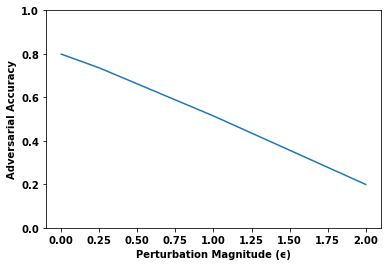

In [22]:
xdata.plot()
plt.xlabel("Perturbation Magnitude (ϵ)")
plt.ylabel("Adversarial Accuracy")
plt.ylim(0, 1)